In [1]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter



import os
from getpass import getpass
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator


from datasets import load_dataset
from haystack import Document
from inputs import MATRIX, NOTES_PER_EXERCISE

In [2]:
template = """
You are an HR consultant with expertise in evaluating human psychology and behavior.

An assessment of a candidate has produced two artifacts: 1. observation notes 2. an evaluation matrix with a scale from 1 (poor) to 4 (excellent)

Your task is to analyze both the observation notes and the evaluation matrix to determine if they are coherent with each other. Please follow these steps:
    1. Review the observation notes and the evaluation matrix carefully.
    2. Compare the observations with the ratings in the matrix for each skill.
    3. Assess whether the ratings in the matrix align with the observations described.

Based on your analysis, provide your findings in the following JSON format

  "skill_name_1": coherence_level_1,
  "skill_name_2": coherence_level_2,
  // Add entries for all skills from the matrix
  "is_matrix_and_notes_coherent": true_or_false


- Replace `skill_name_1`, `skill_name_2`, etc., with the names of the skills listed in the matrix.
- Replace `coherence_level_1`, `coherence_level_2`, etc., with a coherence score from 0 to 10, where 0 indicates no coherence and 10 indicates perfect coherence.
- Set the `is_matrix_and_notes_coherent` key to `true` if the matrix and notes are coherent, or `false` if they are not.

Explain every single coherence score and cite the exact text from the notes that made you make a certain decision.

{{observation_notes}}

{{matrix}}

Reply in German.
"""
promptbuilder = PromptBuilder(template)

In [3]:
generator = AmazonBedrockGenerator(model="anthropic.claude-3-5-sonnet-20240620-v1:0", max_length=4000, truncate=False)

/Users/denys/projects/llm-sandbox/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
# for uebung_name in NOTES_PER_EXERCISE:
#     final_prompt = template.format(matrix=MATRIX, observation_notes=NOTES_PER_EXERCISE[uebung_name])
#     results = generator.run(final_prompt)
#     print(f"********************* {uebung_name}")
#     print(results['replies'][0])

In [5]:
routes = [
        {
            "condition": "{{'false' in replies[0]}}",
            "output": "{{replies[0]}}",
            "output_name": "not_ok",
            "output_type": str,
        }
    ]
router = ConditionalRouter(routes=routes)

In [6]:
pipe = None
pipe = Pipeline()

pipe.add_component("router", router)
pipe.add_component("prompt_builder", promptbuilder)
pipe.add_component("generator", generator)


pipe.connect("prompt_builder", "generator")
pipe.connect("generator.replies", "router")

🚅 Components
  - router: ConditionalRouter
  - prompt_builder: PromptBuilder
  - generator: AmazonBedrockGenerator
🛤️ Connections
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> router.replies (List[str])

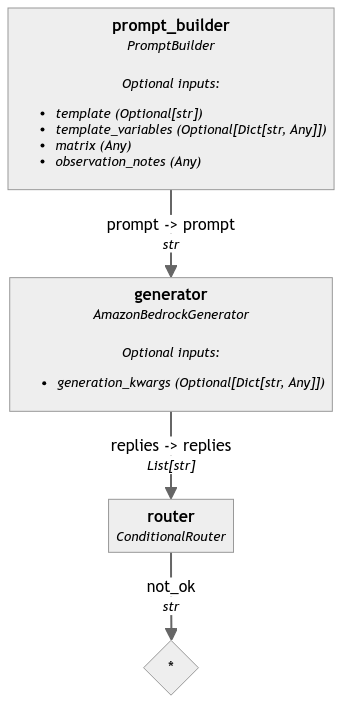

In [7]:
pipe.show()

In [8]:
response = pipe.run(data={"prompt_builder": {"observation_notes": NOTES_PER_EXERCISE['Präsentation und Interview 1'], "matrix": MATRIX}})

In [9]:
for result in response['router']:
    print(result)
    print(response['router'][result])

not_ok
Hier ist meine Analyse der Kohärenz zwischen den Beobachtungsnotizen und der Bewertungsmatrix, dargestellt im gewünschten JSON-Format mit Erklärungen:

{
  "Kunden verstehen": 9,
  "Wertschätzend zusammenarbeiten": 4,
  "Andere gewinnen": 8,
  "Leistung erbringen": 9,
  "Auf Effizienz fokussieren": 10,
  "Unternehmenswert schaffen": 8,
  "Intelligente Lösungen entwickeln": 7,
  "Neue Wege gehen": 6,
  "Veränderung leben": 5,
  "Zukunftsorientierung führen": 4,
  "Orientierung geben": 7,
  "Vertrauen leben": 9,
  "is_matrix_and_notes_coherent": false
}

Erklärungen:

1. "Kunden verstehen" (9/10):
   Die Notizen erwähnen: "Geht mit Offenheit an zwischenmenschliche Beziehungen heran und besitzt daher ein großes Netzwerk bei Kunde X". Dies zeigt ein hohes Verständnis für Kunden, was mit der Bewertung von 3,5 übereinstimmt.

2. "Wertschätzend zusammenarbeiten" (4/10):
   Die Bewertung von 2 steht im Widerspruch zu Aussagen wie "Beweist im Arbeitsstil eine hohe Strukturorientierung, l